In [1]:
import engine as ng
from pathlib import Path
import pandas as pd
import json
from typing import List, Callable, Dict, Tuple
import networkx as nx
from matplotlib import pyplot as plt
from engine.graph_io import import_graph
import numpy as np

data_path = Path("data")

In [2]:
def plot_ingredient_info(bipartite_graph: nx.Graph, ingredient_cutoff_percentage=0.9):
    ingredient_with_occurrence = [(len(list(bipartite_graph.neighbors(ingredient))) , ingredient) for ingredient in bipartite_graph.nodes if bipartite_graph.nodes[ingredient]["type"] == "ingredient"]
    ingredient_with_occurrence = sorted(ingredient_with_occurrence)

    # Extract the ingredient names and occurrence values
    occurrences = [x[0] for x in ingredient_with_occurrence]
    ingredients = [i for i,x in enumerate(ingredient_with_occurrence)]

    def plot_row(ingredients, occurrences: list, axs, apply_cutoff=False):
        # Compute the cumulative sum of the occurrence values
        cumulative_occurrences = np.cumsum(occurrences)
        inverse_cumulative_occurrences = np.cumsum(list(reversed(occurrences)))

        cutoff_index = -1
        total = cumulative_occurrences[-1]
        for i, cumsum in enumerate(inverse_cumulative_occurrences):
            if cumsum / total >= ingredient_cutoff_percentage:
                cutoff_index = len(ingredients) - i - 1
                break

        if apply_cutoff:
            ingredients = ingredients[cutoff_index:]
            occurrences = occurrences[cutoff_index:]
            cumulative_occurrences = np.cumsum(occurrences)

        # Plot the histogram
        axs[0].bar(ingredients, occurrences)
        axs[0].set_xlabel('Ingredients')
        axs[0].set_ylabel('Occurrence')
        axs[0].set_title('Ingredient Occurrence Histogram' if not apply_cutoff else f"Cutoff at {ingredient_cutoff_percentage * 100}%")

        axs[1].boxplot(occurrences)
        axs[1].set_xlabel('Data')
        axs[1].set_ylabel('Ingredient Occurrence')
        axs[1].set_title('Boxplot of Ingredient Occurrence' if not apply_cutoff else f"Cutoff at {ingredient_cutoff_percentage * 100}%")

        # Plot the cumulative occurrence
        axs[2].plot(ingredients, cumulative_occurrences)
        if cutoff_index != -1 and not apply_cutoff:
            axs[2].plot([ingredients[cutoff_index], ingredients[cutoff_index]], [0, cumulative_occurrences[-1]], cumulative_occurrences)
        axs[2].set_xlabel('Ingredients')
        axs[2].set_ylabel('Cumulative Occurrence')
        axs[2].set_title('Cumulative Occurrence of Ingredients' if not apply_cutoff else f"Cutoff at {ingredient_cutoff_percentage * 100}%")

    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3)
    plot_row(ingredients, occurrences, axs[0])
    plot_row(ingredients, occurrences, axs[1], apply_cutoff=True)

    # Adjust the layout of the subplots
    plt.tight_layout()
    # Set the size of the figure
    fig.set_size_inches(10, 6)
    fig.suptitle('Ingredient Info')

    plt.plot()


# Foodcom

In [4]:
bipartite_graph = import_graph(data_path / "graphs" / "foodcom" / "bipartite_recipe_ingredient.graphml")

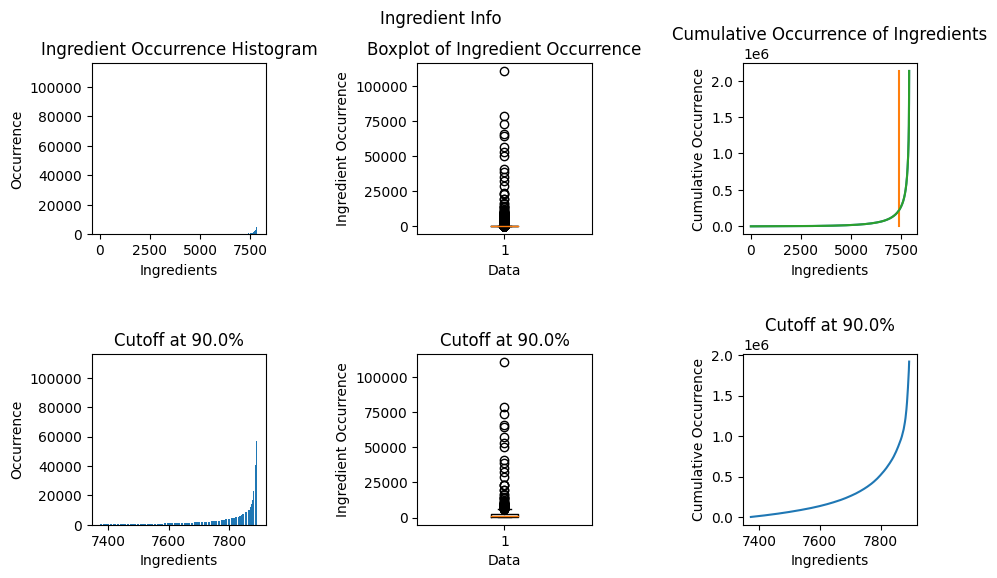

In [8]:
plot_ingredient_info(bipartite_graph)

# RecipeNLG

In [3]:
bipartite_graph = import_graph(data_path / "graphs" / "recipenlg" / "bipartite_recipe_ingredient.graphml")

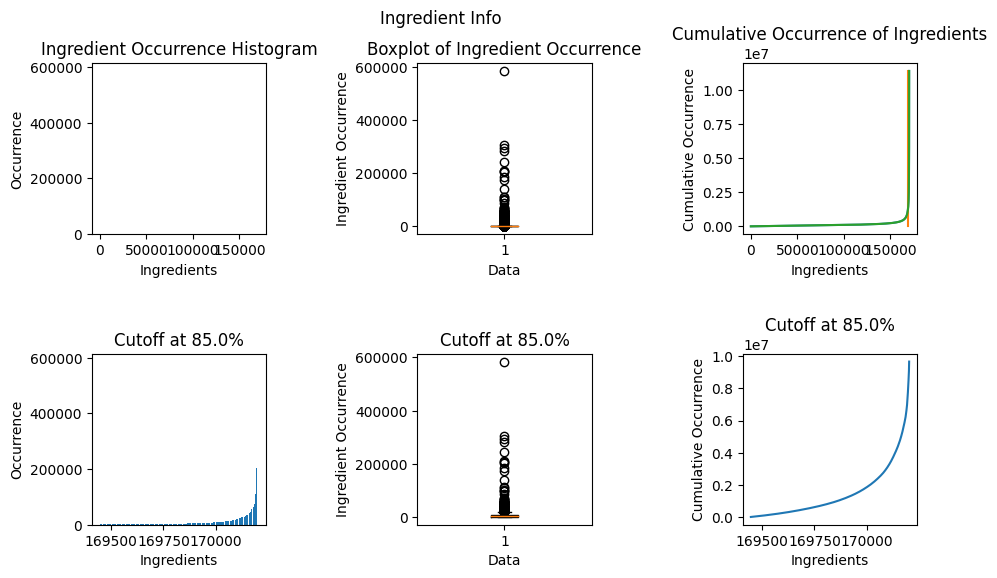

In [4]:
plot_ingredient_info(bipartite_graph, ingredient_cutoff_percentage=0.85)